# Сложение ошибок в сетях со множеством выходов в Pytorch

## Подготовка 

### Подключение библиотек 

In [1]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
from torchviz import make_dot

### Сеть со множеством выходов  

Вместо нейронной сети будем использовать вычислительный граф (по сути одно и тоже)

In [2]:
class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()
    
    def right(self,x):
        a = torch.tanh(x)
        b = torch.tan(a)
        return b.sum()
        
    def center(self,x):
        a = torch.tan(x)
        b = torch.cos(a)
        return b.mean()
    
    def left(self,x):
        a = torch.cos(x)
        b = torch.tanh(a)
        return b.sum()
    
    def forward(self, x):
        a = torch.sin(x)
        c = 2 * a
        loss1 = self.left(c[:8])
        loss2 = self.center(c[8:16])
        loss3 = self.right(c[16:24])
        return loss1, loss2, loss3

In [3]:
model = TinyModel()

### Функция получения ошибок 

Функция генерирует фиксированный вход и возвращает ошибки 

In [4]:
def get_losses():
    torch.manual_seed(89)
    input = torch.linspace(0., 2. * math.pi, steps=24, requires_grad=True)
    loss1, loss2, loss3 = model(input)
    return input, loss1, loss2, loss3

### Функции для печати вычислительного графа 

In [5]:
def print_graph(x):
    return make_dot(x, params=dict(model.named_parameters()))

In [6]:
def save_graph_to_png(x, title):
    print_graph(x).render(title, format="png")

## Два эквивалентных способа обратного распространения ошибки в сетях с множеством выходов 

<a href="https://stackoverflow.com/questions/53994625/how-can-i-process-multi-loss-in-pytorch/53997034#53997034"> Ссылка на источник </a>

Если сеть имеет множество выходов, то backward по сумме выходов эквивалентен backward-у по каждому из них 

### backward по сумме ошибок

In [7]:
def print_base_graph():
    fig, ax = plt.subplots(1, figsize=(25,25))
    ax.set_title('base_graph')
    ax.axis('off')
    image = plt.imread('base_graph.png')
    ax.imshow(image)

    plt.show()

In [8]:
input, loss1, loss2, loss3 = get_losses()

In [9]:
loss = loss1 + loss2 + loss3

In [10]:
base_graph = loss.clone()

In [11]:
save_graph_to_png(base_graph, 'base_graph')

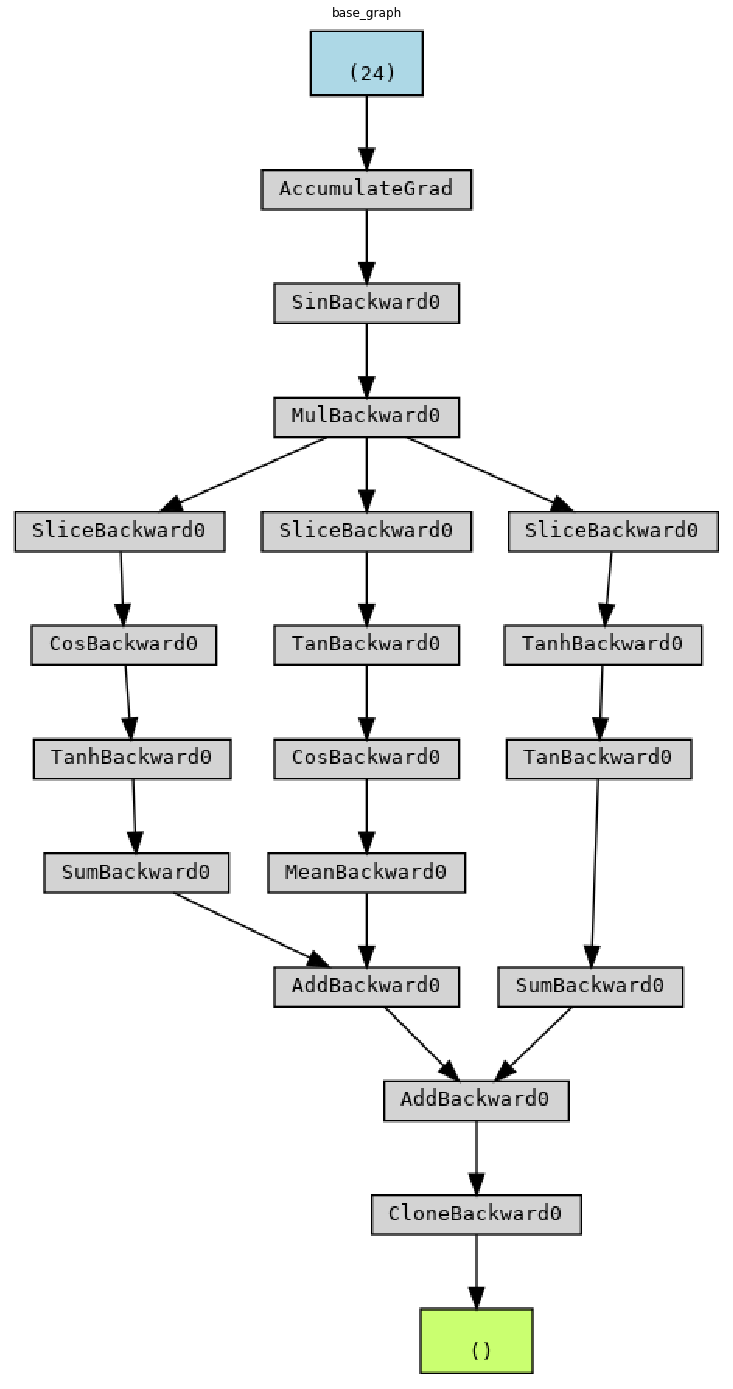

In [12]:
print_base_graph()

In [13]:
loss.backward()
base_grad = input.grad.clone()
print(base_grad)

tensor([ 0.0000, -0.5113, -1.1510, -1.3410, -0.8646, -0.3277,  0.1054,  0.5801,
         3.9009,  0.0103,  0.4007,  0.0736, -0.0736, -0.4007, -0.0103, -3.8987,
        -0.1770, -0.0299,  0.0950,  0.2901,  0.6806,  1.3305,  1.8787,  2.0000])


### backward по каждому выходу

In [14]:
def print_losses_png():
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,45))

    for column in range(3):
        ax1 = plt.subplot2grid((1, 3), (0, column))
        title = "loss" + str(column + 1)
        ax1.set_title(title)
        ax1.axis('off')
        image = plt.imread(title + ".png")
        ax1.imshow(image)
    
    plt.show()

In [15]:
input, loss1, loss2, loss3 = get_losses()

In [16]:
save_graph_to_png(loss1, 'loss1'); save_graph_to_png(loss2, 'loss2'); save_graph_to_png(loss3, 'loss3')

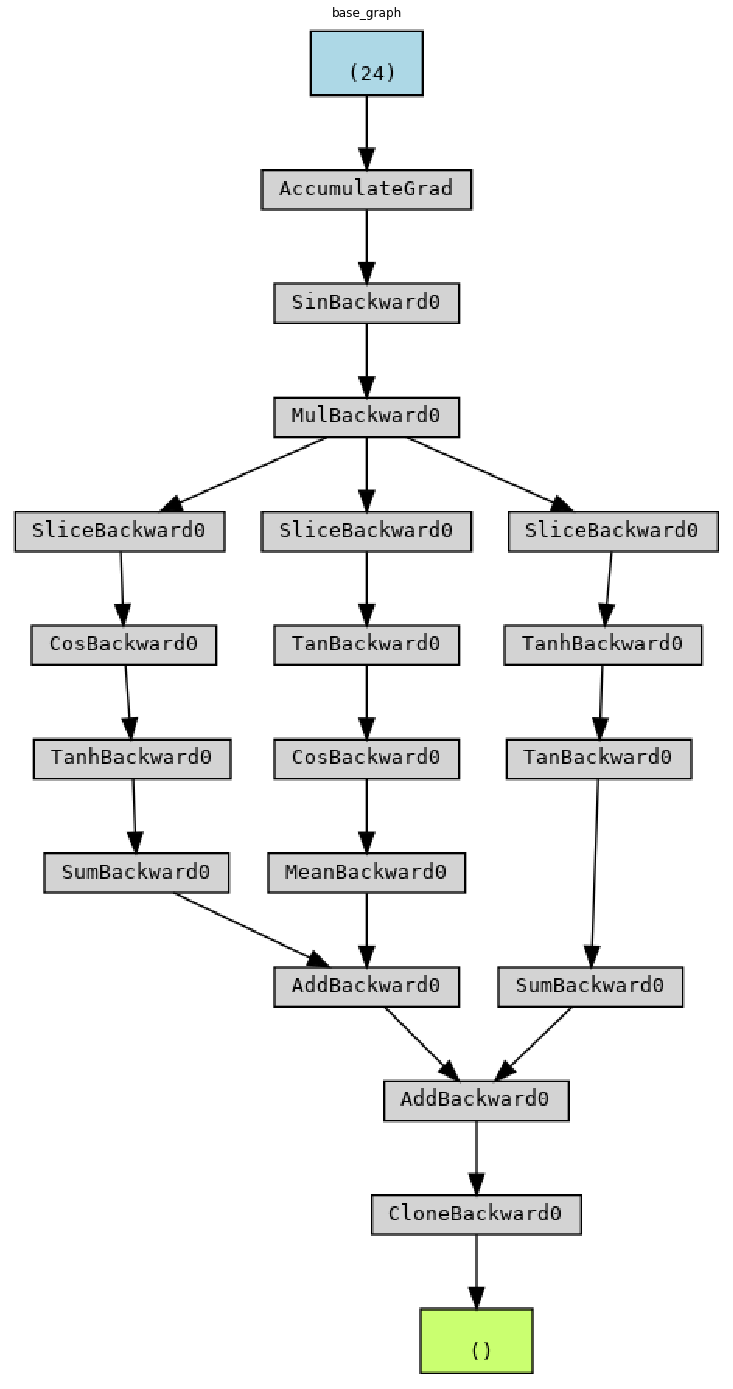

In [17]:
print_base_graph()

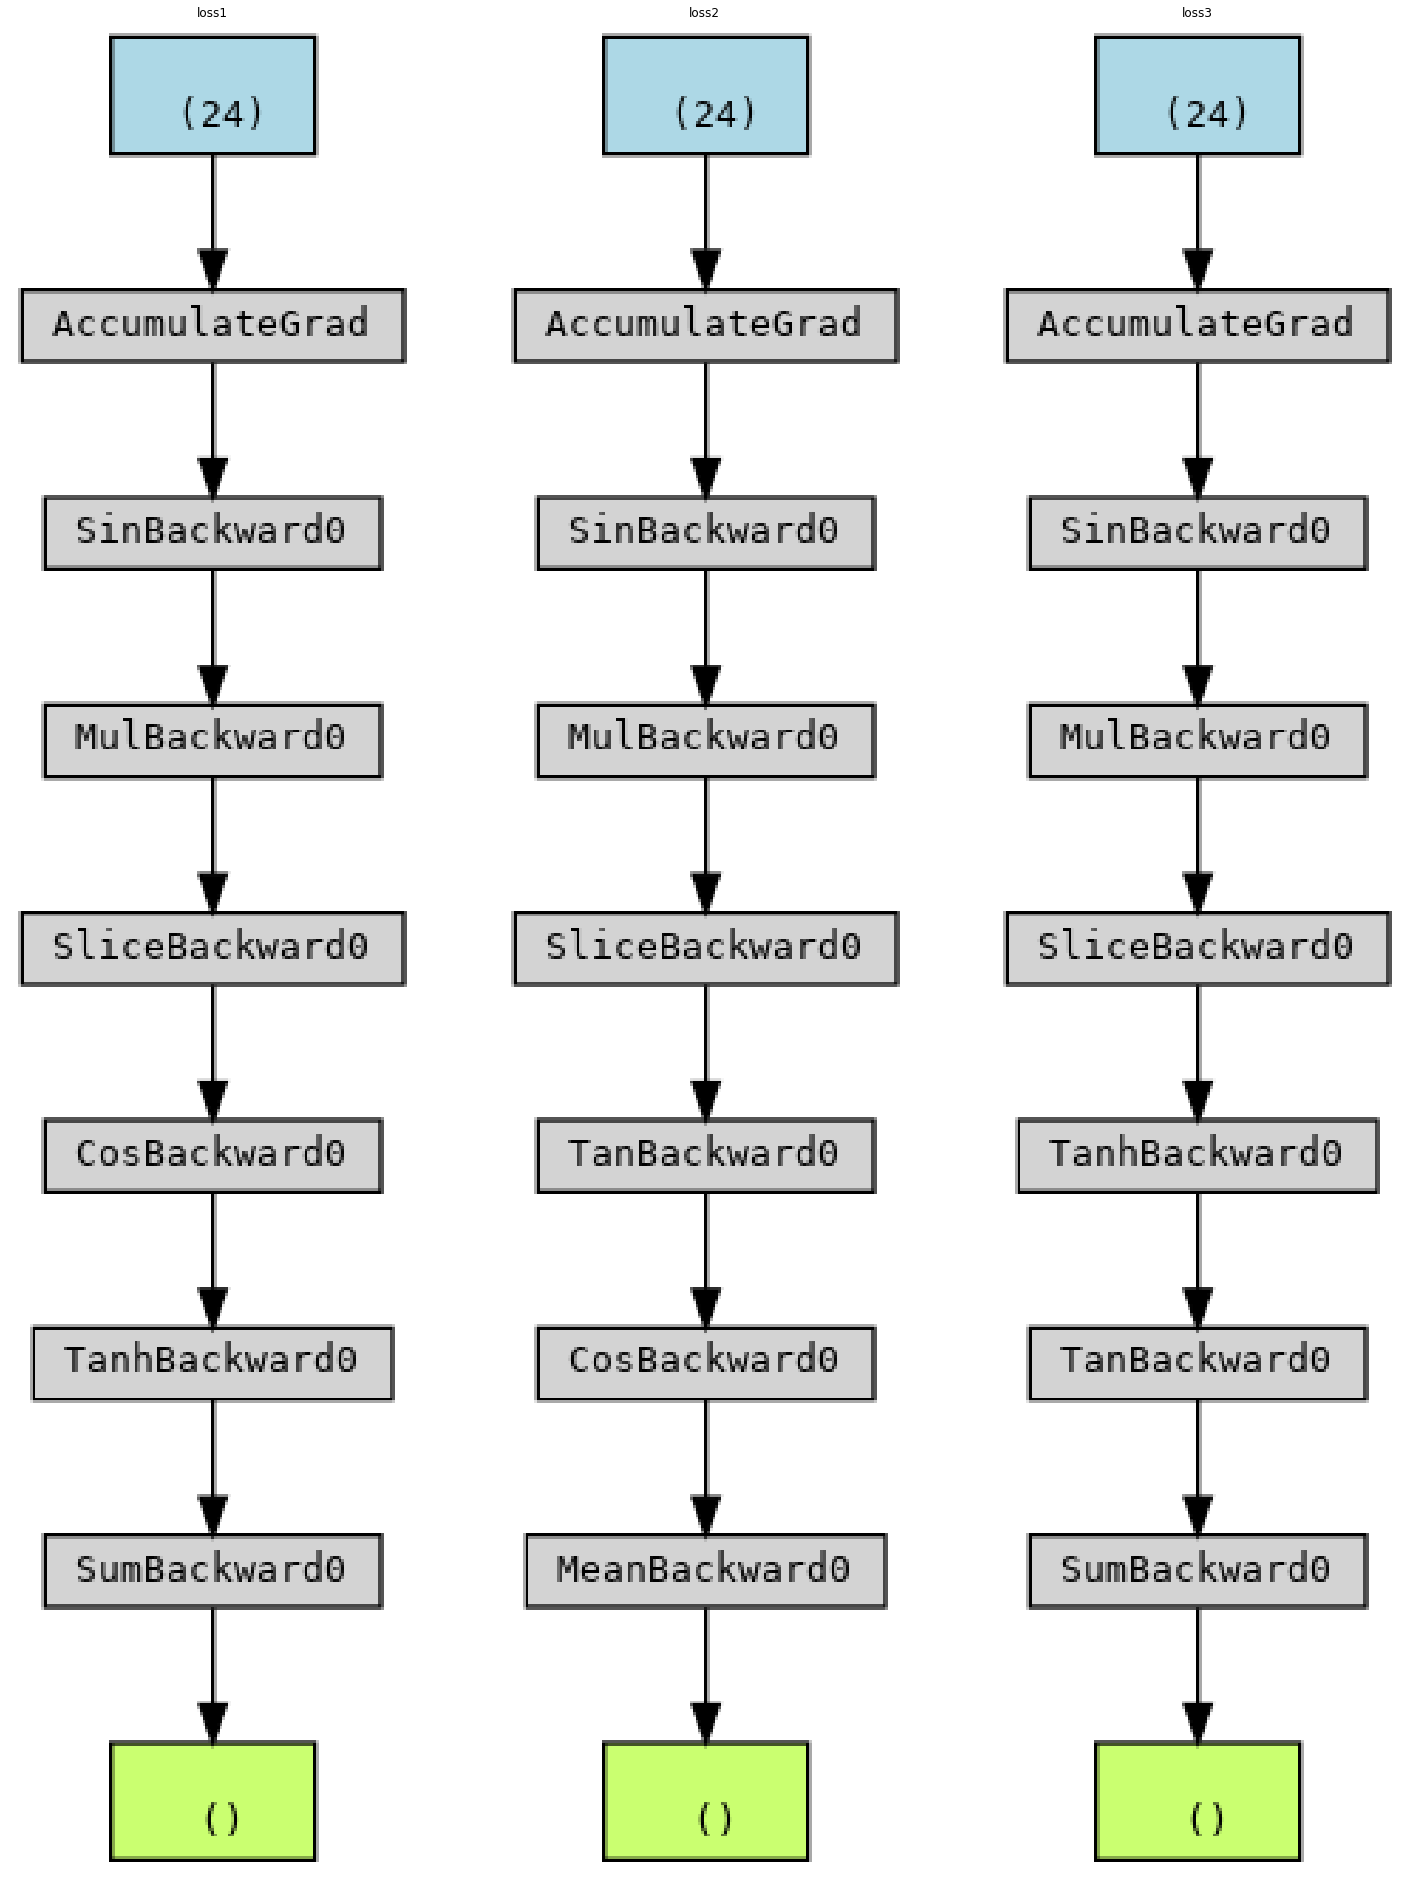

In [18]:
print_losses_png()

In [19]:
loss1.backward(retain_graph=True)

In [20]:
loss2.backward(retain_graph=True)

In [21]:
loss3.backward()

In [22]:
print(input.grad)

tensor([ 0.0000, -0.5113, -1.1510, -1.3410, -0.8646, -0.3277,  0.1054,  0.5801,
         3.9009,  0.0103,  0.4007,  0.0736, -0.0736, -0.4007, -0.0103, -3.8987,
        -0.1770, -0.0299,  0.0950,  0.2901,  0.6806,  1.3305,  1.8787,  2.0000])


In [23]:
input.grad == base_grad

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True])

Обратите внимание на параметр **retain_graph=True** в функции backward, без него вычислительный граф будет уничтожен после первого вызова функции backward. См. документацию https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html

## In-place операции 

Обратите внимание, что операции на месте меняют вычислительный граф

In [24]:
def compare_with_base_graph(graph_name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25,45))

    for column in range(2):
        ax1 = plt.subplot2grid((1, 3), (0, column))
        title = 'base_graph' if column == 0 else graph_name
        ax1.set_title(title)
        ax1.axis('off')
        image = plt.imread(title + ".png")
        ax1.imshow(image)
    
    plt.show()

In [25]:
input, loss1, loss2, loss3 = get_losses()

In [26]:
loss1 += loss1 + loss2 + loss3

In [27]:
save_graph_to_png(loss1, 'In-place')

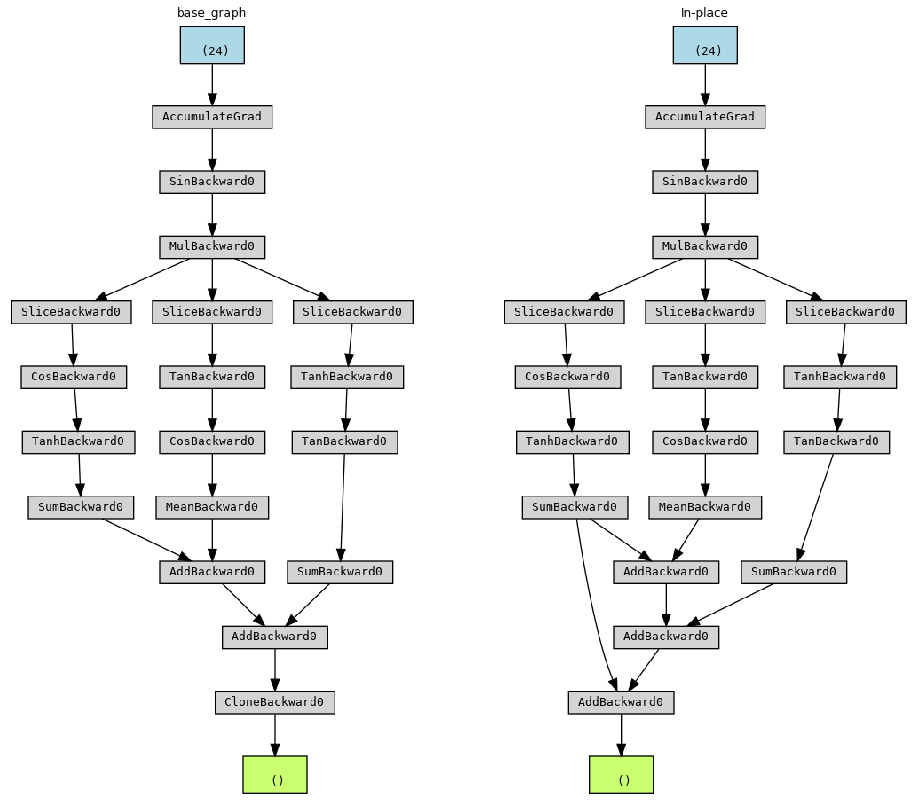

In [28]:
compare_with_base_graph('In-place')

In [29]:
loss1.backward()

In [30]:
input.grad

tensor([ 0.0000, -1.0226, -2.3020, -2.6820, -1.7291, -0.6555,  0.2109,  1.1601,
         3.9009,  0.0103,  0.4007,  0.0736, -0.0736, -0.4007, -0.0103, -3.8987,
        -0.1770, -0.0299,  0.0950,  0.2901,  0.6806,  1.3305,  1.8787,  2.0000])

In [31]:
base_grad

tensor([ 0.0000, -0.5113, -1.1510, -1.3410, -0.8646, -0.3277,  0.1054,  0.5801,
         3.9009,  0.0103,  0.4007,  0.0736, -0.0736, -0.4007, -0.0103, -3.8987,
        -0.1770, -0.0299,  0.0950,  0.2901,  0.6806,  1.3305,  1.8787,  2.0000])

In [32]:
base_grad == input.grad

tensor([ True, False, False, False, False, False, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True])

Как следствие изменился и градиент. Старайтесь избегать In-place операций в вычислительных графах 

### Маленькая тонкость 

Обратите внимание, если пересоздать одну из переменных при сложении ошибок (сохранить в нее результат), то результаты конечно же совпадут 

In [33]:
input, loss1, loss2, loss3 = get_losses()

In [34]:
loss2 = loss1 + loss2 + loss3

In [35]:
save_graph_to_png(loss2, 'resave loss')

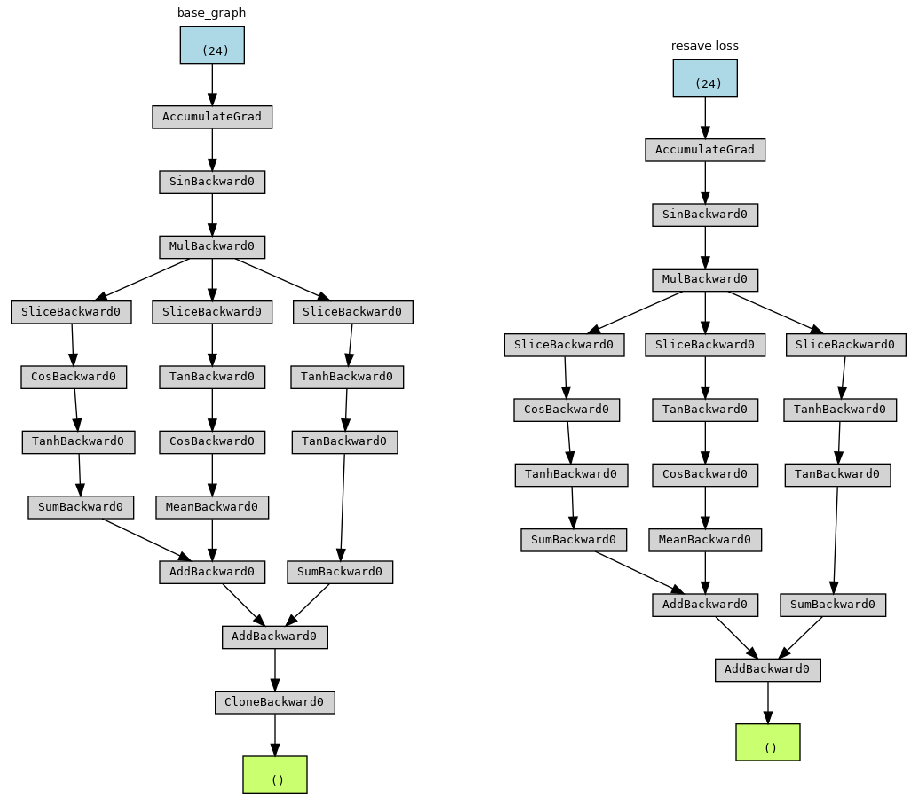

In [36]:
compare_with_base_graph('resave loss')

In [37]:
loss2.backward()

In [38]:
input.grad == base_grad

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True])

In [39]:
============================================================

SyntaxError: invalid syntax (<ipython-input-39-b6af01ee3de8>, line 1)

## Сложения множества loss-ов

<a href="https://discuss.pytorch.org/t/how-to-combine-multiple-criterions-to-a-loss-function/348">Ссылка на источник </a>

Так, как функция sum из python просто применяет оператор + ко всем элементам списка (смотрите исходный код функции <a href="https://github.com/python/cpython/blob/135cabd328504e1648d17242b42b675cdbd0193b/Python/bltinmodule.c"> builtin_sum_impl </a> ), мы можем сложить все loss-ы в список и использовать ее для суммирования

In [ ]:
input, loss1, loss2, loss3 = get_losses()

In [ ]:
loss_list = []

In [ ]:
loss_list.append(loss1); loss_list.append(loss2); loss_list.append(loss3)

In [ ]:
loss = sum(loss_list)

In [ ]:
print_graph(base_graph)

In [ ]:
print_graph(loss)

In [ ]:
loss.backward()

In [ ]:
input.grad == grad1

**Внимание** 

Мы не можем складывать ошибки с помощью torch.sum. Так как он принимает на вход тензор

In [ ]:
input, loss1, loss2, loss3 = get_losses()

In [ ]:
loss_list.append(loss1); loss_list.append(loss2); loss_list.append(loss3)

torch.sum(loss_list) # При выполнении выдаст ошибку 

### Суммирование ошибок при помощи словаря

Очень часто loss-ы складывают в словарь

In [ ]:
input, loss1, loss2, loss3 = get_losses()

In [ ]:
losses = {'l1': loss1, 'l2': loss2, 'l3': loss3}

Тогда доступны два варианта суммирования:

Первый <a href="https://github.com/pytorch/vision/blob/59ec1dfd550652a493cb99d5704dcddae832a204/references/detection/engine.py"> отсюда</a> (более популярный)

In [ ]:
loss_sum = sum(loss for loss in losses.values())

Второй <a href="https://github.com/facebookresearch/detectron2/search?q=loss_dict&type=code">отсюда</a> 

In [ ]:
loss_sum2 = sum(losses.values())

In [ ]:
print_graph(loss_sum)

In [ ]:
print_graph(loss_sum2)

Результаты эквивалентны

## Сложение абсолютных значений losso-ов 

До сих пор мы складывали графы, но что если мы хотим получить значение функции потерь для отчета ? 

Для этого используется метод **detach**, который возвращает копию тензора, отвязанную от графа. См <a href="https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html#torch.Tensor.detach">документацию</a>

In [ ]:
input, loss1, loss2, loss3 = get_losses()

In [ ]:
loss_sum = loss1.detach() + loss2.detach() + loss3.detach()

In [ ]:
loss_sum

In [ ]:
print_graph(loss_sum)

В случаи, когда потеря тензор состоит из одного элемента также можно использовать функцию item, которая вернет значение (просто число). См <a href="https://pytorch.org/docs/stable/generated/torch.Tensor.item.html#torch.Tensor.item">документацию</a>

In [ ]:
loss_sum = loss1.item() + loss2.item() + loss3.item()

In [ ]:
loss_sum

print_graph(loss_sum) # Вызовет ошибку так как это не тензор